In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import sklearn 
import numpy as np 

import gensim
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
"""
Data ingestion and preperation

To prevent any data leakage text snippets from the same book are only allwed to either be in the test or the train split.
    """

df = pd.read_json('gutenberg-dataset-v2.json')                                               # Import Dataset

df = df[df['date'] >= 1820]
df = df[df['date'] <= 1920]

df.drop(df[df['text'].apply(lambda x: len(x) == 0)].index, inplace=True)                     # Drop empty books

unique_books = df['title'].unique()                                                          # List of unique books 
train_books, test_books = train_test_split(unique_books, test_size=0.1, random_state=42)     # Split the list 

train = df[df['title'].isin(train_books)].reset_index()                                      # Select train snippets

test = df[df['title'].isin(test_books)]                                                      # Select test snippets 

earliest_date = train['date'].min()
latest_date = train['date'].max()

samples_list = []
for year in range(earliest_date, latest_date + 1):
    df_year = train[train['date'] == year]
    if len(df_year) > 100:
        samples = df_year.sample(100, random_state=42)
        samples_list.append(samples)
    else:
        samples_list.append(df_year)
train_final  = pd.concat(samples_list)
train_final

earliest_date = test['date'].min()
latest_date = test['date'].max()

samples_list = []
for year in range(earliest_date, latest_date + 1):
    df_year = test[test['date'] == year]
    if len(df_year) > 100:
        samples = df_year.sample(100, random_state=42)
        samples_list.append(samples)
    else:
        samples_list.append(df_year)
test_final  = pd.concat(samples_list)
train_final

1820 1920
1820 1920


,title,author,date,text_ratio,text,text_len_characters,weights
252778,The Voice of Faith in the Valley of Achor: Vol...,J. Church,1820,0.959432,letter xvii valley of achor march my kind frie...,10293,1.000000
251132,The Voice of Faith in the Valley of Achor: Vol...,J. Church,1820,0.964678,astonish you but god knoweth i lie nota future...,10221,0.050000
251133,The Voice of Faith in the Valley of Achor: Vol...,J. Church,1820,0.964678,what to be for ever banished from godfrom jesu...,10274,0.050000
251134,The Voice of Faith in the Valley of Achor: Vol...,J. Church,1820,0.964678,humbling views of your own nothingness an earn...,10202,0.050000
251142,The Voice of Faith in the Valley of Achor: Vol...,J. Church,1820,0.964678,rock i wet with the showers from the mountains...,9986,0.050000
...,...,...,...,...,...,...,...
196030,Illumination and Its Development in the Presen...,Sidney Farnsworth,1920,0.963414,inserted if the artist is able to paint little...,11003,0.038462
37436,The Conquest of the Old Southwest; the romanti...,Archibald Henderson,1920,0.926781,flourish the people on the south side of the k...,12154,0.034483
180379,"""Barbarous Soviet Russia""",Isaac McBride,1920,0.967656,of his recovery with the exception of those da...,12883,0.052632
181122,The Little House,Coningsby Dawson,1920,0.961206,purpose i believe the purpose was to be happy ...,10500,0.250000


In [4]:
train_final


,index,title,author,date,text_ratio,text,text_len_characters,weights
15,212055,"A Five Years' Residence in Buenos Ayres, Durin...",George Thomas Love,1820,0.961988,the frigate in which he had taken his passage ...,11689,0.040000
9,225783,Summary Narrative of an Exploratory Expedition...,Henry Rowe Schoolcraft,1820,0.954532,water the mosquitos were so pertinacious at th...,11123,0.014493
115,176974,"Memoirs of the Life of Sir Walter Scott, Volum...",J. G. Lockhart,1820,0.964346,if she had been a married woman these five yea...,11131,0.019608
78,225765,Summary Narrative of an Exploratory Expedition...,Henry Rowe Schoolcraft,1820,0.954532,transcribers note inconsistent hyphenation and...,11895,0.014493
66,212043,"A Five Years' Residence in Buenos Ayres, Durin...",George Thomas Love,1820,0.961988,of st james which some south american deputies...,11031,0.040000
...,...,...,...,...,...,...,...,...
84296,197560,The Young Physician,Francis Brett Young,1920,0.961545,into living flesh a strange sensation but the ...,10945,0.016393
83654,81462,Chicken Little Jane,Lily Munsell Ritchie,1920,0.958721,just as thick as yes interrupted katy and i gu...,11064,0.038462
83534,189231,A Company of Tanks,William Henry Lowe Watson,1920,0.968870,forward all the country was returning to heath...,11109,0.030303
83762,294453,Horrors of vaccination exposed and illustrated /,Chas. M. Higgins,1920,0.968402,and church in the land over the judges bench i...,11517,0.043478


In [5]:
def train_and_vectorize_docs(train_df, vector_size=40, min_count=4, epochs=30):
    """
    Train a Doc2Vec model on a given DataFrame containing textual data and date information.

    Parameters:
    - train_df (pandas.DataFrame): Input DataFrame with 'text' and 'date' columns.
    - vector_size (int): Dimensionality of the document vectors in the Doc2Vec model.
    - min_count (int): Ignores all words with a total frequency lower than this.
    - epochs (int): Number of iterations over the entire dataset during training.

    Returns:
    - pandas.DataFrame: DataFrame containing vectors, original text, date ranges, and other information.
    """
    
    train_df['tokenized_text'] = train_df['text'].apply(word_tokenize)                                                   # Tokenization of each snippet

    new_df = train_df.groupby('date')['tokenized_text'].agg(lambda x: sum(x, [])).reset_index()                          # Groupe snippets by Year

    train_corpus = []                                                                                                    # Preptaring the data for the 
                                                                                                                         # Doc2Vec model 
    for i, words in enumerate(new_df['tokenized_text']):
        tagged_doc = TaggedDocument(words=words, tags=[str(i)])
        train_corpus.append(tagged_doc)

    model = gensim.models.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=epochs)                           # Train the Doc2Vec model
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    # Infer Vectors and save in column (maybe usfull if we want to use them for further processing)
    vectors = [model.infer_vector(words) for words in new_df['tokenized_text']]
    new_df['vectors'] = vectors

    return new_df, model
    
new_df, model = train_and_vectorize_docs(train_final)
new_df.head(5)

,date,tokenized_text,vectors
0,1820,"[the, frigate, in, which, he, had, taken, his,...","[-6.2525167, -1.8684152, 1.1747131, 3.0384567,..."
1,1821,"[hospital, or, rather, an, almshouse, for, six...","[-4.92171, -10.261277, -1.3506608, 10.351115, ..."
2,1822,"[at, the, comdiefranaise, as, there, had, been...","[-7.953076, 14.671577, -3.3835647, 2.0411117, ..."
3,1823,"[behemoth, and, leviathan, from, the, book, of...","[-6.651124, -1.9095792, -2.7258317, 5.5978374,..."
4,1824,"[he, had, rendered, the, most, important, serv...","[-0.085562274, -2.050004, -2.9588716, 1.692287..."


In [6]:
"""
    Evaluate the performance of a trained Doc2Vec model on a set of test documents.
    
    The 'text' column in the test DataFrame is tokenized using the NLTK library's word_tokenize function. 
    A vector representation is inferred for the tokenized text of the test document using the trained Doc2Vec model (model).
    The most similar documents to the inferred vector are retrieved from the Doc2Vec model's document vectors 
"""

for i in range(20):
    test_sample = pd.DataFrame(test_final.iloc[i]).transpose()
    test_sample['tokenized_text'] = test_sample['text'].apply(word_tokenize)
    
    vector = model.infer_vector(test_sample['tokenized_text'].iloc[0])
    #print(vector)
    
    similar_docs = model.dv.most_similar([vector])
    #print(similar_docs[0][0])
    print("Title", test_sample.title.values, "Published", test_sample.date.values,"Estimate", new_df.iloc[int(similar_docs[0][0])].date)

Title ['The Voice of Faith in the Valley of Achor: Vol. 2 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 1823
Title ['The Voice of Faith in the Valley of Achor: Vol. 1 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 1883
Title ['The Voice of Faith in the Valley of Achor: Vol. 1 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 1823
Title ['The Voice of Faith in the Valley of Achor: Vol. 1 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 1883
Title ['The Voice of Faith in the Valley of Achor: Vol. 1 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 1823
Title ['The Voice of Faith in the Valley of Achor: Vol. 1 [of 2] / being a series of letters to several friends on religious subjects'] Published [1820] Estimate 182

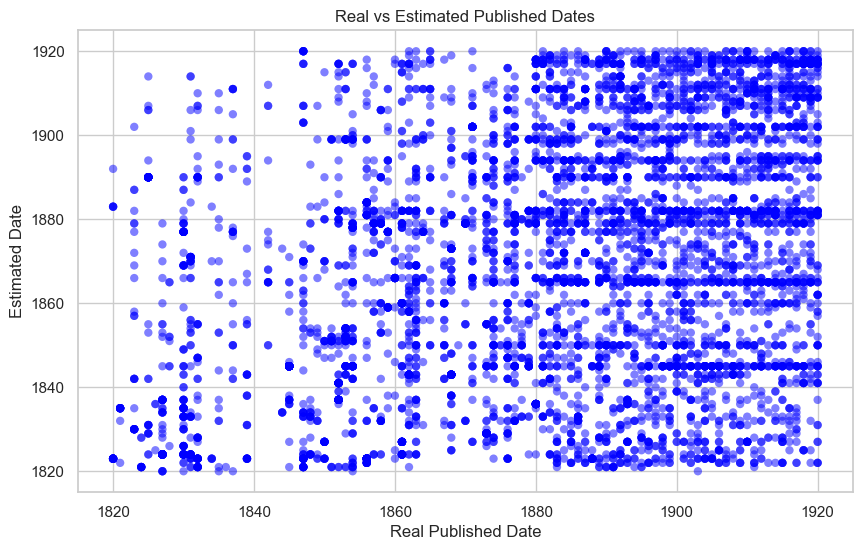

RMSE: 34.868414445716375
R2: -0.8250809618419095


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize  
import seaborn as sns

results_df = pd.DataFrame(columns=['Real Published Date', 'Estimated Date'])
test = test_final
for i in range(len(test)):
    test_sample = pd.DataFrame(test.iloc[i]).transpose()
    test_sample['tokenized_text'] = test_sample['text'].apply(word_tokenize)
    
    vector = model.infer_vector(test_sample['tokenized_text'].iloc[0])
    
    similar_docs = model.dv.most_similar([vector])
    
    real_published_date = test_sample.date.values[0]
    estimated_date = new_df.iloc[int(similar_docs[0][0])].date

    results_df = pd.concat([results_df, pd.DataFrame({'Real Published Date': [real_published_date], 'Estimated Date': [estimated_date]})], ignore_index=True)


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x=results_df['Real Published Date'], y=results_df['Estimated Date'], color='blue', alpha=0.5, edgecolor='none')
plt.title('Real vs Estimated Published Dates')
plt.xlabel('Real Published Date')
plt.ylabel('Estimated Date')
plt.grid(True)
plt.savefig('DOC2VEC_results.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()  # If you want to display the plot

rmse = np.sqrt(mean_squared_error(results_df['Real Published Date'], results_df['Estimated Date']))
print(f"RMSE: {rmse}")

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(results_df['Real Published Date'], results_df['Estimated Date'])
print(f"R2: {r2}")